In [4]:
'''
Importing Libraries
'''
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import time
import json
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import SmoothingFunction
smoothing_fn = SmoothingFunction().method4
print(torch.__version__)


1.6.0


In [5]:
from torchtext.data import Field, BucketIterator

In [6]:
import pickle

In [7]:
'''
Import Data from Pickle 
'''
with open('./en_hi_data/en_hi.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.head())

                              english                           hindi
57382              Who is this man?\n             -ये आदमी कौन है ?\n
28149        And the other brother?\n                 और दूसरे भाई?\n
80284  - Greetings, Mustakeen bhai.\n        नमस्ते, Mustakeen भाई।\n
63596     Please, reason with them.\n  कृपया, उन लोगों के साथ कारण.\n
9459        There's a howling gale.\n             तेज़ हवा आ रही है।\n


In [8]:
dataset = {'en' : [], 'hi' : [] }
for k in data['english'].keys():
    dataset['en'].append(data['english'][k]) 
    dataset['hi'].append(data['hindi'][k])


In [9]:
'''
Creating Train Dev and Test Datasets
'''
X_train, X_test, y_train, y_test = train_test_split(data['english'] , data['hindi'], test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_test , y_test, test_size=0.2, random_state=42)

In [10]:
'''
Merging into Dataframes
'''
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
dev_data = pd.concat([X_dev, y_dev], axis=1)

In [11]:
'''
Creating CSV files for Training, Dev and Test Datasets
'''

# with open("train_data.csv", "w") as outfile:  
#     train_data.to_csv(outfile, sep=',', encoding='utf-8') 
# with open("test_data.csv", "w") as outfile:  
#     test_data.to_csv(outfile, sep=',', encoding='utf-8') 
# with open("dev_data.csv", "w") as outfile:  
#     dev_data.to_csv(outfile, sep=',', encoding='utf-8')  

'\nCreating CSV files for Training, Dev and Test Datasets\n'

In [12]:
import unicodedata
def unicode_to_ascii(s):
    return ''.join( c for c in unicodedata.normalize( 'NFD', s ) if unicodedata.category( c ) != 'Mn' )

'''
Tokenization for English
'''
def add_spaces_eng(w):
#     print(w)
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)    
    w = w.lower()
    w = re.sub(r"[^a-z?.!,]+", " ", w)    
    w = w.strip()
#     print(w)
    arr = unicode_to_ascii(w)
#     print(arr)
    return arr.split()

'''
Tokenization for Hindi
'''
def add_spaces_hin(w):
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()
    arr = unicode_to_ascii(w)
#     print(arr)
    return arr.split()

In [13]:
'''
Creating Torchtext Fields
'''
english = Field(tokenize = add_spaces_eng,lower = True,init_token = "<s>",eos_token = "<e>")
hindi = Field(tokenize = add_spaces_hin,lower = True,init_token = "<s>",eos_token = "<e>")

/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [14]:
'''
Creating dataset tensors for training 
'''
from torchtext.data import TabularDataset, Field 
train_data, valid_data, test_data = TabularDataset.splits( path="./", train="train_data.csv", 
                                                          validation="dev_data.csv",
                                                          test="test_data.csv",  format="CSV",
                                                          fields= [("english", english), ("hindi", hindi)])

/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [15]:
'''
Creating Vocab
'''
english.build_vocab(train_data.english,max_size = 10000,min_freq = 3)
hindi.build_vocab(train_data.hindi,max_size = 10000,min_freq = 2)


In [16]:
'''
Defining Encoder
'''
class Encoder(nn.Module):
    
    def __init__(self, input_size, embedding_size, hidden_size, decoder_hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, decoder_hidden_size)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, bidirectional=True)

    def forward(self, x):
        embedding = self.dropout(self.embedding(x))
        outputs, hidden = self.rnn(embedding)
        temp = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = torch.tanh(self.fc(temp))        
        return hidden, outputs

In [17]:
'''
Defining Decoder for Attention
'''
class Decoder(nn.Module):
    
    def __init__(
        self, embedding_size, encoding_hidden_size, hidden_size, output_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn = nn.Linear((encoding_hidden_size * 2) + hidden_size, hidden_size)
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.v = nn.Linear(hidden_size, 1, bias = False)
        self.rnn = nn.GRU((encoding_hidden_size * 2) + embedding_size, hidden_size)
        self.fc = nn.Linear((encoding_hidden_size * 2) + hidden_size + embedding_size , output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)
        embedding = self.dropout(self.embedding(x))
#         print('hi',hidden.shape, cell.shape[0])
        hidden1 = hidden.unsqueeze(1).repeat(1, cell.shape[0], 1)
        cell1 = cell.permute(1, 0, 2)
        temp = torch.cat((hidden1, cell1), dim = 2)
        energy = torch.tanh(self.attn(temp)) 
        attention = self.v(energy).squeeze(2)
        a = F.softmax(attention, dim=1)
        a = a.unsqueeze(1)
        cell1 = cell.permute(1, 0, 2)
        weighted = torch.bmm(a, cell1)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedding, weighted), dim = 2)
#         hidden = hidden.reshape(1, hidden.shape[0], hidden.shape[1])
#         print(rnn_input.shape, hidden.shape)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        x = torch.cat((output.squeeze(0), weighted.squeeze(0), embedding.squeeze(0)), dim = 1)
        predictions = self.fc(x)       
        return predictions, hidden.squeeze(0)

In [18]:
'''
Creating the Model
'''
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.decoder.output_size
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)
        x = target[0]
        for t in range(1, target_len):
            output, hidden = self.decoder(x, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_force_ratio
            best_guess = output.argmax(1)
            x = target[t] if random.random() < teacher_force else best_guess
        return outputs

In [19]:
'''
Important Parmeters
'''
num_epochs = 10 
learning_rate = 0.03
batch_size = 128

In [20]:
'''
HyperParameters
'''
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(english.vocab)
input_size_decoder = len(hindi.vocab)
output_size = len(hindi.vocab)
num_layers = 1
enc_dropout = 0.5
dec_dropout = 0.5

In [21]:
'''
BucketIterator
'''
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), 
                                                                           batch_size = batch_size,
                                                                           device = device, sort = False, 
                                                                           sort_within_batch = True, 
                                                                           sort_key = lambda x:len(x.hindi))

/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [22]:
encoder_net = Encoder(input_size_encoder, 128,256,256, num_layers, enc_dropout)
decoder_net = Decoder(128, 256, 256, output_size, num_layers, dec_dropout)

In [23]:
'''
Initiating Model
'''
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_( param.data, -0.08, 0.08 )

model = Seq2Seq(encoder_net, decoder_net).to(device)
model.apply( init_weights )
'''
Using Adam Optimizer
'''
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
pad_idx = english.vocab.stoi[english.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)

In [25]:
'''
Train Function (For Training set )
'''
def train(model, iterator, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0

    for i, batch in enumerate( iterator ):
        source = batch.english
        target = batch.hindi

        optimizer.zero_grad()

        output = model( source, target )

        output_dim = output.shape[-1]

        output = output[1:].view( -1, output_dim )
        target = target[1:].view( -1 )

        loss = criterion( output, target )

        loss.backward()

        torch.nn.utils.clip_grad_norm_( model.parameters(), clip )

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len( iterator )


In [26]:
'''
Evaluate function to test the model of Validation Set 
'''

def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate( iterator ):
            source = batch.english
            target = batch.hindi

            output = model( source, target, 0 )  # turn off teacher forcing

            output_dim = output.shape[-1]

            output = output[1:].view( -1, output_dim )
            target = target[1:].view( -1 )

            loss = criterion( output, target )

            epoch_loss += loss.item()

    return epoch_loss / len( iterator )


In [27]:
'''
Calculating the bleu score
'''
from torchtext.data.metrics import bleu_score
def bleu(data, model, hindi, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["english"]
        trg = vars(example)["hindi"]

        prediction = translate_sentence(model, src, english, hindi, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)

'''
For the checkpoints
'''
def save_checkpoint(state, filename="my_checkpoint_attention.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [28]:
'''
Training the model
'''
tr_loss = []
val_loss = []
for epoch in range(num_epochs):
    train_loss = train( model, train_iterator, optimizer, criterion, 1 )
    tr_loss.append(train_loss)
    valid_loss = evaluate( model, validation_iterator, criterion)
    val_loss.append(valid_loss)
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)
    
    print( 'Epoch:', epoch + 1 )
    print( 'Train Loss:', round(train_loss,2) )
    print( 'Val. Loss:', round(valid_loss,2) )

/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


=> Saving checkpoint
Epoch: 1
Train Loss: 14.06
Val. Loss: 11.64
=> Saving checkpoint
Epoch: 2
Train Loss: 10.87
Val. Loss: 9.49
=> Saving checkpoint
Epoch: 3
Train Loss: 10.09
Val. Loss: 9.2
=> Saving checkpoint
Epoch: 4
Train Loss: 8.69
Val. Loss: 8.68
=> Saving checkpoint
Epoch: 5
Train Loss: 8.34
Val. Loss: 8.11
=> Saving checkpoint
Epoch: 6
Train Loss: 7.91
Val. Loss: 7.13
=> Saving checkpoint
Epoch: 7
Train Loss: 7.5
Val. Loss: 7.87
=> Saving checkpoint
Epoch: 8
Train Loss: 7.51
Val. Loss: 8.04
=> Saving checkpoint
Epoch: 9
Train Loss: 7.61
Val. Loss: 7.79
=> Saving checkpoint
Epoch: 10
Train Loss: 6.95
Val. Loss: 7.34


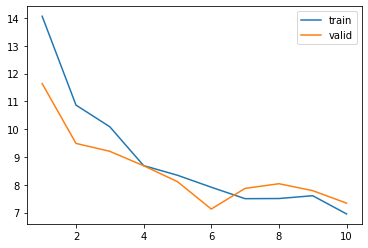

In [29]:
'''
Plotting the graphs
'''
x=[i for i in range(1,11)]
# train_loss=[31.762, 35.006, 31.393, 26.409, 17.735, 17.401, 15.518, 14.293]
# val_loss = [28.044, 29.231, 27.516, 17.169, 14.759, 15.629, 13.822, 13.314]
plt.plot(x,tr_loss,label='train')
plt.plot(x,val_loss,label='valid')
plt.legend() 
plt.show()

In [30]:
'''
Translating Sentences
'''

def translate_sentence(model, sentence, english, hindi, device, max_length=20):
    
    if type(sentence) == str:
        tokens = add_spaces_eng(sentence)
    else:
        tokens = [token.lower() for token in sentence]

#     print(tokens)

    tokens.insert(0, english.init_token)
    tokens.append(english.eos_token)
    text_to_indices = [english.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)
    with torch.no_grad():
        hidden, cell = model.encoder(sentence_tensor)
    outputs = [hindi.vocab.stoi["<s>"]]
    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()
        outputs.append(best_guess)
        if output.argmax(1).item() == hindi.vocab.stoi["<e>"]:
            break
    translated_sentence = [hindi.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]


In [31]:
'''
Testing the model
'''
num = 1
for i in test_data:
    print(f'Example #{num}' )
    num+=1
    print('English Input:' ,' '.join(i.english))
    print('Expected Output:',' '.join(i.hindi))
    print('Actual Output:',' '.join(translate_sentence(model, ' '.join(i.english), english, hindi, device)))
    print()

Example #1
English Input: english
Expected Output: hindi
Actual Output: <unk> <unk> <e>

Example #2
English Input: she s your dream girl !
Expected Output: वो तमहारी डरीमगरल होगी !
Actual Output: म अपन वह ! <e>

Example #3
English Input: that s the guy i shot .
Expected Output: कि मझ गोली मार दी आदमी ह .
Actual Output: यही परसकार परापत <e>

Example #4
English Input: don t worry , little birdie .
Expected Output: चिता मत करो , ननह पछी।
Actual Output: <unk> मत <unk> <e>

Example #5
English Input: to the best .
Expected Output: - सबस अचछा करन क लिए .
Actual Output: <unk> <unk> <e>

Example #6
English Input: we are still a go .
Expected Output: हमअभीभी एक जानाकररहह
Actual Output: हम अभी जाना <e>

Example #7
English Input: my name s emma lyndsey .
Expected Output: मरा नाम एमा लिडसी ह .
Actual Output: मरा मरा मरा मरा मरा मरा मरा मरा मरा मरा मरा <e>

Example #8
English Input: yes , because i m a man .
Expected Output: हा , क‍योकि म परष ह .
Actual Output: हा , <e>

Example #9
English Input: yo

Actual Output: लकिन वादा नही <e>

Example #82
English Input: getting along is exhausting .
Expected Output: दोसताना वयवहार बनाना काफी थका दन वाला ह।
Actual Output: <unk> <unk> <e>

Example #83
English Input: let me tell you something .
Expected Output: एक बात मझ कह लन दीजिए .
Actual Output: मझ कछ <e>

Example #84
English Input: you wanna stop gambling .
Expected Output: तमह रोक जआ .
Actual Output: तमह तमह <unk> <e>

Example #85
English Input: yes , my lord
Expected Output: - हा मर परभ
Actual Output: हा , वह <e>

Example #86
English Input: we can make it .
Expected Output: हम यह कर सकत ह .
Actual Output: हम इस बात करनी <e>

Example #87
English Input: that was a romantic proposal .
Expected Output: यही कारण ह कि एक रोमाटिक परसताव था।
Actual Output: परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार परसकार

Example #88
English Input: no , not that door .
Expected Output: नही , वह दरवाजा नही।
Actual Output: न

Actual Output: हम म <e>

Example #155
English Input: hey , you a motor head ?
Expected Output: अर , तम एक मोटर सिर ?
Actual Output: अर , ? <e>

Example #156
English Input: yeah , we can handle it .
Expected Output: - हा , हम इस सभाल कर सकत ह।
Actual Output: हा हा , <e>

Example #157
English Input: he had no pain .
Expected Output: उनह किसी तरह का दःख नही था . .
Actual Output: वह वह वह नही वह था। <e>

Example #158
English Input: many mistakes have been made .
Expected Output: कई गलतिया की गई ह .
Actual Output: <unk> <unk> <e>

Example #159
English Input: yes , i was floored .
Expected Output: - हा , म फिदा हो गया था।
Actual Output: हा , वह था। <e>

Example #160
English Input: a king isn t born , alexander .
Expected Output: एक राजा सिकदर , पदा नही हआ ह .
Actual Output: <unk> परसकार नही , <e>

Example #161
English Input: can you fix my leg ?
Expected Output: आप मरा पर ठीक कर सकत ह ?
Actual Output: मरा <unk> ? <e>

Example #162
English Input: that is very sexy .
Expected Output: यह बहत सक

Example #222
English Input: i m so sorry , excuse me .
Expected Output: i'm very sorry , i'm sorry .
Actual Output: मझ अफसोस , <e>

Example #223
English Input: never ask a man s earnings .
Expected Output: आदमियो की कमायी कभी नही पछनी चाहिय .
Actual Output: <unk> वह नही <unk> <e>

Example #224
English Input: tell me . . who opened the gate ?
Expected Output: बताओ me . . who गट खोला ?
Actual Output: सर <unk> <e>

Example #225
English Input: don t judge me , lucas .
Expected Output: i justice , lucas .
Actual Output: मझ मत <e>

Example #226
English Input: please , what are you doing ?
Expected Output: कर , तम कया कर रह हो ?
Actual Output: तमह <unk> ? <e>

Example #227
English Input: i ve heard that one before .
Expected Output: -मन पहल भी सना ह।
Actual Output: म इस को <e>

Example #228
English Input: the situation was under control .
Expected Output: सथिति नियतरण म था .
Actual Output: <unk> वह था। <e>

Example #229
English Input: how would you do that ?
Expected Output: आप यह कस करना होग

Actual Output: मरा <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example #300
English Input: your life s in danger .
Expected Output: आपका जीवन खतर म ह।
Actual Output: <unk> <unk> <e>

Example #301
English Input: you ever been rock climbing ?
Expected Output: -आपन कभी चटटानो की चढाई की ह ?
Actual Output: - तमह ? <e>

Example #302
English Input: yes , i know !
Expected Output: -मझ पता ह मन तमहारी डील छीनी .
Actual Output: हा , वह <e>

Example #303
English Input: there s a place i know .
Expected Output: म जानता ह कि वहा एक जगह ह .
Actual Output: वहा <unk> परसकार ह <e>

Example #304
English Input: see you later .
Expected Output: ~ अलविदा दखो तम .
Actual Output: यही ओकजा <unk> <e>

Example #305
English Input: that girl shouldn t survive .
Expected Output: उस लडकी को जीवित रहन क लिए नही करना चाहिए।
Actual Output: तो वह नही <e>

Example #306
English Input: i ll see you later , hank .
Expected Output: म बाद म हाक आप दखग।
A

Actual Output: यही परसकार चीज नही ? <e>

Example #369
English Input: are we not with you ?
Expected Output: कया हम तमहार साथ नही ह ?
Actual Output: हम कही म <e>

Example #370
English Input: i ll be right there .
Expected Output: म अभी वहा हो जाएगा .
Actual Output: म अभी वहा <e>

Example #371
English Input: are you kidding ?
Expected Output: ~ आप मजाक कर रह हो ?
Actual Output: बवकफ तमह ? <e>

Example #372
English Input: i believe it s insured .
Expected Output: म यह बीमा किया जाता ह विशवास .
Actual Output: म इस <e>

Example #373
English Input: have you come to shop ?
Expected Output: शॉपिग करन आए हो ?
Actual Output: <unk> पास ? <e>

Example #374
English Input: i was like , ok .
Expected Output: मझ लगा , ओक .
Actual Output: म बवकफ था। <e>

Example #375
English Input: and remain open long enough
Expected Output: और खला रहना काफी दर तक
Actual Output: <unk> परसकार परापत <e>

Example #376
English Input: tell me , i am waiting .
Expected Output: मझ बताओ , म इतजार कर रहा ह।
Actual Output: सर ,

Actual Output: अब वहा <e>

Example #453
English Input: what are you talking about ?
Expected Output: आप किस बार म बात कर रह ह ?
Actual Output: म कया ? <e>

Example #454
English Input: woman speaking native language
Expected Output: महिला अपनी मातभाषा म बोल रही ह:
Actual Output: म बोल रहा ह: <e>

Example #455
English Input: we have to get out .
Expected Output: हम बाहर निकलना होगा .
Actual Output: हम हम परापत करनी <e>

Example #456
English Input: so why is he coming ?
Expected Output: तो कयो आ रहा ह ?
Actual Output: कयो <unk> कयो ? <e>

Example #457
English Input: mm , close the deal .
Expected Output: सौदा खतम।
Actual Output: विकटोरिया , <unk> परसकार परापत <e>

Example #458
English Input: who is this guy ?
Expected Output: यह कौन ह ?
Actual Output: यह कौन कौन ? <e>

Example #459
English Input: i think he s mean .
Expected Output: मझ लगता ह कि वह मतलब ह .
Actual Output: म मतलब मतलब <e>

Example #460
English Input: why s he staring at me ?
Expected Output: यह मझ कयो घर रहा ह ?
Actual Out

Actual Output: यह मरा सामान चोरी . <e>

Example #518
English Input: my family deserves it .
Expected Output: मर परिवार क काबिल ह .
Actual Output: मरा मरा <unk> मरा <e>

Example #519
English Input: ma m , in the leopard dress . . .
Expected Output: तदएकीपोशाकम ma' m , . . .
Actual Output: ओकजा म <e>

Example #520
English Input: a g . i . joe flag .
Expected Output: एक जी . आई . जो झडा .
Actual Output: <unk> परसकार <unk> <e>

Example #521
English Input: we re gonna be okay .
Expected Output: हम ठीक हो जाओग .
Actual Output: हम हमला होन वाला <e>

Example #522
English Input: what s the code to d ?
Expected Output: डी227 का कोड कया ह ?
Actual Output: <unk> <unk> ? <e>

Example #523
English Input: you re confusing the kid .
Expected Output: आप बचच को भरमित कर रह ह .
Actual Output: <unk> <unk> <e>

Example #524
English Input: or a feeling of hope .
Expected Output: मझ उममीद स भरना ?
Actual Output: <unk> या <unk> <e>

Example #525
English Input: that is a class ten !
Expected Output: यह वाला तो

Actual Output: तमह <unk> <e>

Example #588
English Input: he was my father !
Expected Output: उनहोन कहा कि मर पिता था !
Actual Output: वह वह टरक वह था। <e>

Example #589
English Input: this painting came in .
Expected Output: यहचितरअदरआया
Actual Output: <unk> परसकार परापत <e>

Example #590
English Input: you won t find them
Expected Output: तम उनह खोज नही पाओग
Actual Output: तो उनह नही उनह नही उनह नही उनह नही उनह नही उनह <e>

Example #591
English Input: heart beating
Expected Output: [दिल की धडकन]
Actual Output: <unk> परसकार परापत <e>

Example #592
English Input: number , fire !
Expected Output: नबर 1 , आग !
Actual Output: <unk> (बीप) <e>

Example #593
English Input: yeah , but , there are . . .
Expected Output: हा , लकिन , दखत ह . . .
Actual Output: हा , <e>

Example #594
English Input: so , if anything happens inside . .
Expected Output: तो , कछ भी अदर होता ह , तो . .
Actual Output: तो , <e>

Example #595
English Input: you want to kill me ?
Expected Output: तम मझ मारना चाहत हो ?
Act

In [33]:
bleu(test_data, model, hindi, english, device)

0.010451113870027083